In [ ]:
'''
This notebook contains the best strategy we found - ML Strategy 7.5.
The scores are better than other strategies in private and public both.
The hyperparameters were found on FOODS_1 dept and same were used on all dept, all years.
This IPYNB uses myfeatures.py file for functions required for feature engineering.
'''

In [ ]:
'''
Performance reached for 7.5 :
'''

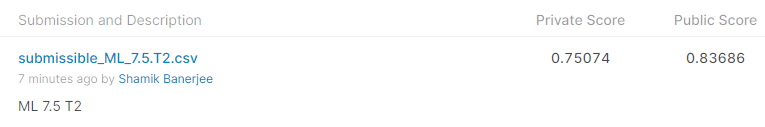

### Installations

In [ ]:
'''
These installations will be required to run the code.
'''
# !unzip m5-forecasting-accuracy.zip

# !apt-get update
# !apt-get install wget

# ! pip install pandas
# ! pip install calender
# ! pip install numpy
# ! pip install datetime
# ! pip install matplotlib
# ! pip install collections
# ! pip install random
# ! pip install tqdm
# ! pip install sklearn
# ! pip install lightgbm

### Imports

In [ ]:
from IPython.display import clear_output 
import pandas as pd
import calendar
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output as cclear
from sklearn.metrics import mean_squared_error as mse
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer
import lightgbm as lgb
from math import sqrt
from itertools import zip_longest
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_randFloat
import joblib
import xgboost as xgb

In [ ]:
'''
Import myfeature.py
'''
import myfeature

### Fetching the Data

In [ ]:
'''
Get the m5-forecasting-accuracy.zip from data section here at Kaggle. A Kaggle account is required-
https://www.kaggle.com/c/m5-forecasting-accuracy/data.

It is suggested to use cliget extension on Firefox Browser to get the files. 
1. Just add the extension and click on 'Download All' button on Kaggle page's Data section.
2. Now as the download begins you may pause it immediately as downloading is not required.
3. Now click on the extension icon and select 'm5-forecasting-accuracy.zip' and you will be shown a link.
4. Paste that link here in any cell with an exclamation mark prefixed to it and execute the cell to download the data.
5. Unzip using '!unzip m5-forecasting-accuracy.zip' command.
6. Done.
'''

### Loading CSVs

In [ ]:
'''
We need all CSVs except sample_submission.csv to perform the feature engineering.
'''

def get_csv(X):
    return pd.read_csv(X)

calender, sales_train_ev, sales_train_val, sell_prices =  get_csv('calendar.csv'), \
                                                          get_csv('sales_train_evaluation.csv'), \
                                                          get_csv('sales_train_validation.csv'), \
                                                          get_csv('sell_prices.csv')

### Creating some features

In [ ]:
non_numeric_col_list = ['id','item_id','dept_id','cat_id','store_id','state_id','d', 'date']
store_dict = {'CA_1':0, 'CA_2':0, 'CA_3':0, 'CA_4':0, 'WI_1':0, 'WI_2':0, 'WI_3':0, 'TX_1':0, 'TX_2':0, 'TX_3':0}

In [ ]:
'''
We are creating a dict for days with at least one event.
'''

days_with_event = []
for i in range(len(calender)):
    days_with_event.append(myfeature.event1_check(i)) or (myfeature.event2_check(i))
    
l = [int(i) for i in days_with_event]
event_dict = dict(zip(calender.d, l))

In [ ]:

week_no_d_dict = dict(zip(calender.wm_yr_wk, calender.d))
sell_prices['d'] = sell_prices['wm_yr_wk'].map(week_no_d_dict)
sell_prices['item_d_col'] = sell_prices['item_id'] + sell_prices['d']
sale_price_dict = dict(zip(sell_prices['item_d_col'], sell_prices['sell_price']))

sell_prices = sell_prices.drop('d', 1)
sell_prices = sell_prices.drop('item_d_col', 1)

### Hyperparameter Tuning Strategy - 4

In [ ]:
# Tuning for one dept and all years

In [ ]:
%%time

'''
For evaluation csv, we add columns from 1942 to 1970 so that we can predict. We will need these columns to transform
the data into long form.
Then we use the feature_engineer function to add the features and make the transformation.
'''

df = sales_train_ev.copy()
empty_list = [0]*30490
for i in range(1942, 1970):
    df['d_'+str(i)] = empty_list
df = myfeature.feature_engineer(df)

In [ ]:
%%time

'''
The Generic code for Hyperparameter Tuning requires 'dept_name_to_tune_on' variable to have the dept name to be specified.
Among departments FOODS_1 has less no of rows so tuning will take lesser time, however any dept can be used. 
'''

new_df = df
new_df = new_df[new_df.dept_id == dept_name_to_tune_on]
print('Total rows: ', len(new_df))

rows_per_day = len(new_df[new_df.d == 'd_1'])
print('Rows per day: ', rows_per_day)

new_df['day_of_month'] = new_df['day_of_month'].fillna(0)
new_df = new_df.astype({'day_of_month': 'int32'})               # Making day_of_month column as int
new_df['date'] = new_df['date'].astype(str)

y = new_df.unit_sale                                            # getting the label
new_df = new_df.drop('unit_sale', axis=1)

print('Encoding categorical features...')
le, new_df = myfeature.encode_cat_cols(new_df)                  # Encoding Categorical Columns

X = new_df

In [ ]:
'''
We use rows_per_day to decide the location of that dept in X data. Every dept has variable no of rows to it's name.
'''

ev_train_start, ev_train_end, val_train_start, val_train_end = rows_per_day*(0), rows_per_day*1941,\
                                                               rows_per_day*(0), rows_per_day*1913

print('Getting X_train, y_train...')
                                                                
X_train, y_train = X.iloc[ev_train_start:ev_train_end], y[ev_train_start:ev_train_end] 
X_test, y_test = X.iloc[ev_train_end:], y[ev_train_end:]

In [ ]:
%%time
'''
This is the generic tuning code used for tuning on all strategies tried.
'''
param_list_to_try = {
            'subsample' : sp_randFloat(, ),
            'learning_rate' : sp_randFloat(, ),
            'num_leaves' : sp_randint(, ),
            'min_data_in_leaf' : sp_randint(, ),
            'reg_lambda' : sp_randFloat(, ),
            'feature_fraction' :sp_randFloat(, ),
            'max_bin' : sp_randint(, ),
            'n_estimators' : sp_randint(, )}

no_of_hyperparameters = 
clf = LGBMRegressor(boosting_type = 'gbdt', 
                    objective = 'tweedie', 
                    tweedie_variance_power = ,
                    metric = 'rmse',
                    subsample_freq = ,
                    boost_from_average = False)

random_search = RandomizedSearchCV( estimator = clf, 
                                    param_distributions = param_list_to_try,
                                    n_iter = no_of_hyperparameters,
                                    scoring = make_scorer(mse, greater_is_better = False), 
                                    cv = , 
                                    refit = True, 
                                    random_state = 314, 
                                    verbose = True)

random_search.fit(X_train, y_train)
print('Best score reached: {} with params: {} '.format(random_search.best_score_, random_search.best_params_))

In [ ]:
'''
Best score reached: -6.837664909865839 with params: {'feature_fraction': 0.9542804698211322, 
'learning_rate': 0.04354167654567688, 'max_bin': 112, 'min_data_in_leaf': 3942, 'n_estimators': 1207, 
'num_leaves': 2086, 'reg_lambda': 0.9597502600785817, 'subsample': 0.37442983123111895} 
'''

### Training Functions

In [ ]:
'''
This function takes input one dept worth of data, it can be from evaluation or validation csv, the function takes care
of that. It fits the model and sends out the labelencoders and predictions. Another function uses the the encoders and 
predictions to roll out final files.
'''

def startegy7dot5T2(new_df, dept):
    print('Using strategy ', strategy)

    evaluation, validation = new_df.id.iloc[0].find('evaluation'), new_df.id.iloc[0].find('validation')
    
    new_df = new_df[new_df.dept_id == dept]
    print('Total rows: ', len(new_df))
    
    rows_per_day = len(new_df[new_df.d == 'd_1'])
    print('Rows per day: ', rows_per_day)
    
    new_df['day_of_month'] = new_df['day_of_month'].fillna(0)
    new_df = new_df.astype({'day_of_month': 'int32'})             # Making day_of_month column as int
    new_df['date'] = new_df['date'].astype(str)

    y = new_df.unit_sale                                          # getting the label
    new_df = new_df.drop('unit_sale', axis=1)

    print('Encoding categorical features...')
    le, new_df = myfeature.encode_cat_cols(new_df)                # Encoding Categorical Columns

    X = new_df
    
    ev_train_start, ev_train_end, val_train_start, val_train_end = rows_per_day*(0), rows_per_day*1941,\
                                                                   rows_per_day*(0), rows_per_day*1913
    
    model = LGBMRegressor(boosting_type = 'gbdt',                 # 7.5 Trial 2
                       objective = 'tweedie',
                       tweedie_variance_power = 1.1,
                       metric = 'rmse',
                       n_estimators = 1207,
                       subsample_freq = 1,
                       learning_rate = 0.04,
                       num_leaves = 2086,
                       reg_lambda = 0.959,
                       min_data_in_leaf = 3942,
                       subsample = 0.37,
                       feature_fraction = 0.95,
                       max_bin = 112,
                       boost_from_average = False)
 
    if evaluation != -1:                                        # if evaluation data
        print('Getting X_train, y_train...')
                                                                
        X_train, y_train = X.iloc[ev_train_start:ev_train_end], y[ev_train_start:ev_train_end] 
        X_test, y_test = X.iloc[ev_train_end:], y[ev_train_end:] 
        
    if validation != -1:                                        # if validation data
        print('Getting X_train, y_train...')
        X_train, y_train = X.iloc[val_train_start:val_train_end], y[val_train_start:val_train_end]
        X_test, y_test = X.iloc[val_train_end:], y[val_train_end:]
    
    print('X_train len', len(X_train), 'y_train len', len(y_train), 'X_test len', len(X_test))
    
    print('Fitting model...')
    model.fit(X_train, y_train)
    print('Fitting done.')
    
    print('Making predictions...')
    train_out = model.predict(X_test)

    print('Done.')
    return le, X_test, train_out

In [ ]:
'''
This function takes the outputs of individual departments and binds them todgether, retransforms the data back into 
daywise horizontal form, renames the columns as required by kaggle for submission and returns the dataframe that we save as
csv.
'''

def get_output_of_eval_or_val(df):
    main_out_df = pd.DataFrame()
    
    list_dept = list(set(df.dept_id))
    for i in list_dept:
        print('Sequence of depts processing: ', list_dept)
        print('Working on Dept: ', i)
        le, X_test, train_out = startegy7dot5T2(df, i)
        print('Reversing the long form...')
        out_df = myfeature.reverse_long_form(le, X_test, train_out)
        main_out_df = pd.concat([main_out_df, out_df], ignore_index=False)
        cclear()

    l = []                                                         # In this part we rename the columns to F_1, F_2 ....
    for i in range(1,29):
        l.append('F'+str(i))
    l = ['id']+l

    main_out_df.columns = l
    
    return main_out_df

### Prediction for Evaluation CSV

In [ ]:
strategy = 7.5                                            # Setting this variable helps in distinguishing during running

In [ ]:
'''
The next two cells get the output for evaluation.csv data.
'''

In [ ]:
%%time
'''
For evaluation csv, we add columns from 1942 to 1970 so that we can predict. We will need these columns to transform
the data into long form.
Then we use the feature_engineer function to add the features and make the transformation.
'''

df = sales_train_ev.copy()
empty_list = [0]*30490
for i in range(1942, 1970):
    df['d_'+str(i)] = empty_list
df = myfeature.feature_engineer(df)

In [ ]:
%%time
main_out_df_ev = get_output_of_eval_or_val(df)
main_out_df_ev.to_csv('main_out_ev.csv')

### Prediction for Evaluation CSV

In [ ]:
'''
The next two cells get the output for validation.csv data.
'''

In [ ]:
%%time
'''
For validation csv, we add columns from 1914 to 1942 so that we can predict. We will need these columns to transform
the data into long form.
Then we use the feature_engineer function to add the features and make the transformation.
'''

df = sales_train_val.copy()
empty_list = [0]*30490
for i in range(1914, 1942):
    df['d_'+str(i)] = empty_list
df = myfeature.feature_engineer(df)

In [ ]:
%%time
main_out_df_val = get_output_of_eval_or_val(df)
main_out_df_val.to_csv('main_out_val.csv')

### Reordering and Saving the final output

In [ ]:
'''
This part makes sure we have columns in right order, the first column should be item ids.
'''
myfeature.reorder_data(sales_train_val, 'main_out_val')
myfeature.reorder_data(sales_train_ev, 'main_out_ev')

In [ ]:
'''
Making sure there is no unnamed column as that can create problem in submission.
'''
main_out_ev = pd.read_csv('main_out_ev.csv')
main_out_ev = main_out_ev.drop(main_out_ev.columns[0], axis=1)

main_out_val = pd.read_csv('main_out_val.csv')
main_out_val = main_out_val.drop(main_out_val.columns[0], axis=1)

sub_df = pd.concat([main_out_ev, main_out_val], ignore_index=True)
sub_df = sub_df.round(2)

In [ ]:
sub_df.to_csv('submissible_ML_.csv', index=False)

In [ ]:
pd.read_csv('submissible_ML_.csv')